## Data Analysis using BulkLMM - BXD Longevity Study

In [1]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim
using Random, Distributions, LoopVectorization
using GeneNetworkAPI, Downloads
using BenchmarkTools

In [2]:
local_path = "../../BulkLMM.jl/src";

#### Marker of interest
- Sdhaf4: on Chr1 at 24 Mb
- Ndufv1: on Chr1 at 22 Mb

#### Phenotype Datasets:
1. Chow diet (BXD mean)
2. High fat diet (BXD mean)
3. Both combined  (BXD mean)
4. Individual BXD (which obviously is both diets and all ages)


#### Data Set: EPFL/ETHZ BXD Liver Proteome CD-HFD (Nov19)

4 age groups, 2 treatments, 1 sex.

### Load datasets:

In [3]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM_Analyses/BXDLongevity"

In [4]:
datafolder_path = "/Users/FredYu/Desktop/WorkNotebooks/BXD-LongevityStudy/Data/GN886-CD-HFD-Individuals/";

#### Individual measurements of all liver proteome:

In [5]:
lp_file_path = joinpath(datafolder_path, "GN886-Liver-Proteome-Individuals.txt"); # from Zach

In [6]:
lp_ind = readdlm(lp_file_path, '\t');

In [7]:
size(lp_ind)

(32446, 316)

In [8]:
any(ismissing.(lp_ind))

false

In [9]:
sum(ismissing.(lp_ind))

0

In [10]:
lp_ind[1:10, 1:10]

10×10 Matrix{Any}:
 "ProbeSetID"                                     …    "H1425"    "H1189"    "H1818"
 "P42209_DESGLNRK_2"                                 11.572     10.486     12.3
 "P42209_GLRPLDVAFLR_3"                              11.535     11.01      11.76
 "Q99M02_VGDPVYR_2"                                  17.638     17.282     17.502
 "Q99M02_VWIYPIK_2"                                  17.611     17.423     17.443
 "Q99M02_LCDPSVK_2"                               …  17.804     17.047     17.343
 "Q99M02_CVLTTVDPDTGIIDR_2"                          16.786     16.425     16.564
 "Q99M02_LVQFDTSMK_2"                                16.318     16.127     16.112
 "Q99M02_QLQQVGTVSK_2"                               16.301     16.007     16.135
 "Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4"     16.229     16.124     16.325

In [11]:
lp_ind_df = DataFrame(lp_ind[2:end, 1:end], lp_ind[1, 1:end]);

In [12]:
lp_ind_df

32445×316 DataFrame
   Row │ ProbeSetID                         H1560   H1424   H1715   H1707   H1 ⋯
       │ Any                                Any     Any     Any     Any     An ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ P42209_DESGLNRK_2                  11.633  10.998  12.519  12.576  10 ⋯
     2 │ P42209_GLRPLDVAFLR_3               11.699  11.54   11.3    11.737  11
     3 │ Q99M02_VGDPVYR_2                   17.598  17.745  17.7    17.625  17
     4 │ Q99M02_VWIYPIK_2                   17.582  17.451  17.734  17.752  17
     5 │ Q99M02_LCDPSVK_2                   17.396  16.966  17.426  17.489  17 ⋯
     6 │ Q99M02_CVLTTVDPDTGIIDR_2           16.727  16.605  16.837  16.817  16
     7 │ Q99M02_LVQFDTSMK_2                 16.258  16.182  16.412  16.357  16
     8 │ Q99M02_QLQQVGTVSK_2                16.229  16.217  16.306  16.326  16
     9 │ Q99M02_KLYPSESYLQNYEVAYPDCSPVHLI…  16.138  16.042  16.344  16.419  16 ⋯
    10 │ Q99M02_GRDCGDEVAQWFTNYLK_3         15.927  15.931  16.151  16.186  16
    11 │ Q99M02_SIYQSSPLFGMYFSVEK_2         15.855  15.017  15.243  15.609  15
   ⋮   │                 ⋮                    ⋮       ⋮       ⋮       ⋮        ⋱
 32436 │ Q80Y56_VYELIDALSK_2                14.865  14.572  14.793  14.678  14
 32437 │ Q9CPW7_DYDFEER_2                   15.224  14.559  15.137  14.947  14 ⋯
 32438 │ Q80W54_SIDFPLTK_2                  14.33   14.045  15.64   15.35   15
 32439 │ Q80W54_SSHSNAYFYGFFK_3             14.166  13.911  13.603  13.562  13
 32440 │ Q80W54_DLYSALIK_2                  13.934  13.277  13.519  13.975  13
 32441 │ Q80W54_NEEVLAVLGHELGHWK_4          12.541  12.581  12.455  12.292  11 ⋯
 32442 │ D3Z4T9_AVGPASILK_2                 15.93   15.465  16.011  16.088  16
 32443 │ Q3UFS0_LLADVTHLLLK_3               7.174   7.645   8.025   7.71    8.
 32444 │ Q62523_VNPFRPGDSEPPVAAGAQR_3       14.483  14.993  14.194  13.81   14
 32445 │ Q62523_GPLSQAPTPAPK_2              12.846  13.724  13.121  13.125  13 ⋯
                                              311 columns and 32424 rows omitted

In [13]:
lp_ind[1:10, 1:10]

10×10 Matrix{Any}:
 "ProbeSetID"                                     …    "H1425"    "H1189"    "H1818"
 "P42209_DESGLNRK_2"                                 11.572     10.486     12.3
 "P42209_GLRPLDVAFLR_3"                              11.535     11.01      11.76
 "Q99M02_VGDPVYR_2"                                  17.638     17.282     17.502
 "Q99M02_VWIYPIK_2"                                  17.611     17.423     17.443
 "Q99M02_LCDPSVK_2"                               …  17.804     17.047     17.343
 "Q99M02_CVLTTVDPDTGIIDR_2"                          16.786     16.425     16.564
 "Q99M02_LVQFDTSMK_2"                                16.318     16.127     16.112
 "Q99M02_QLQQVGTVSK_2"                               16.301     16.007     16.135
 "Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4"     16.229     16.124     16.325

We see that the column names are the sample ids and the row names are the proteomic names.

For this demo we focus on the first liver proteomic, named as "`P42209_DESGLNRK_2`"

In [14]:
strains_info_path = joinpath(datafolder_path, "P42209_DESGLNRK_2.xlsx");
xf = XLSX.readxlsx(strains_info_path)[1][:];

In [15]:
strains_info = DataFrame(xf[9:end, :], xf[8, :]);

In [16]:
strains_info

315×15 DataFrame
 Row │ Index  Name   Value   Sex  Age  Strain  EarTag  Longevity  Tx   RRID    ⋯
     │ Any    Any    Any     Any  Any  Any     Any     Any        Any  Any     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1      H0529  11.201  F    709  DBA/2J  529     missing    HF   JAX:000 ⋯
   2 │ 2      H0532  11.182  F    361  DBA/2J  532     missing    HF   JAX:000
   3 │ 3      H1131  11.322  M    549  DBA/2J  1131    missing    HF   JAX:000
   4 │ 4      H1132  11.86   M    549  DBA/2J  1132    missing    HF   JAX:000
   5 │ 5      H1140  11.961  M    544  DBA/2J  1140    missing    HF   JAX:000 ⋯
   6 │ 6      H1141  11.636  M    544  DBA/2J  1141    missing    HF   JAX:000
   7 │ 7      H1142  12.45   F    549  DBA/2J  1142    missing    HF   JAX:000
   8 │ 8      H1144  11.121  F    212  DBA/2J  1144    missing    HF   JAX:000
   9 │ 9      H1147  12.061  F    212  DBA/2J  1147    missing    CD   JAX:000 ⋯
  10 │ 10     H1812  11.157  F    532  DBA/2J  1812    missing    CD   JAX:000
  11 │ 11     H1818  12.3    F    764  DBA/2J  1818    missing    CD   JAX:000
  ⋮  │   ⋮      ⋮      ⋮      ⋮    ⋮     ⋮       ⋮         ⋮       ⋮       ⋮   ⋱
 306 │ 306    H1228  10.939  F    726  B6D2F1  1228    missing    CD   JAX:100
 307 │ 307    H1230  11.825  F    726  B6D2F1  1230    missing    HF   JAX:100 ⋯
 308 │ 308    H1236  9.966   M    540  B6D2F1  1236    missing    HF   JAX:100
 309 │ 309    H1302  12.589  F    216  B6D2F1  1302    missing    HF   JAX:100
 310 │ 310    H1303  12.343  F    364  B6D2F1  1303    missing    HF   JAX:100
 311 │ 311    H1445  12.235  F    619  B6D2F1  1445    missing    HF   JAX:100 ⋯
 312 │ 312    H1568  11.954  F    552  B6D2F1  1568    missing    CD   JAX:100
 313 │ 313    H1569  11.623  F    552  B6D2F1  1569    missing    CD   JAX:100
 314 │ 314    H2288  12.513  F    547  B6D2F1  2288    missing    HF   JAX:100
 315 │ 315    H2290  12.795  F    547  B6D2F1  2290    missing    HF   JAX:100 ⋯
                                                  6 columns and 294 rows omitted

Extract the two columns containing information about the sample id and which strain the sample is drawn from:

In [17]:
sub_strains_info = DataFrame(Sample = strains_info[:, :Name], Strain = strains_info[:, :Strain])

315×2 DataFrame
 Row │ Sample  Strain 
     │ Any     Any    
─────┼────────────────
   1 │ H0529   DBA/2J
   2 │ H0532   DBA/2J
   3 │ H1131   DBA/2J
   4 │ H1132   DBA/2J
   5 │ H1140   DBA/2J
   6 │ H1141   DBA/2J
   7 │ H1142   DBA/2J
   8 │ H1144   DBA/2J
   9 │ H1147   DBA/2J
  10 │ H1812   DBA/2J
  11 │ H1818   DBA/2J
  ⋮  │   ⋮       ⋮
 306 │ H1228   B6D2F1
 307 │ H1230   B6D2F1
 308 │ H1236   B6D2F1
 309 │ H1302   B6D2F1
 310 │ H1303   B6D2F1
 311 │ H1445   B6D2F1
 312 │ H1568   B6D2F1
 313 │ H1569   B6D2F1
 314 │ H2288   B6D2F1
 315 │ H2290   B6D2F1
      294 rows omitted

Then, filter out those samples that are not from BxD strains:

In [18]:
is_from_BXD = occursin.(r"BXD*", sub_strains_info.Strain);
samples_from_BXD = sub_strains_info[is_from_BXD, :]

265×2 DataFrame
 Row │ Sample  Strain 
     │ Any     Any    
─────┼────────────────
   1 │ H0229   BXD102
   2 │ H0448   BXD102
   3 │ H1358   BXD102
   4 │ H1361   BXD102
   5 │ H1363   BXD102
   6 │ H1498   BXD102
   7 │ H1499   BXD102
   8 │ H1697   BXD102
   9 │ H1743   BXD102
  10 │ H1750   BXD102
  11 │ H1753   BXD102
  ⋮  │   ⋮       ⋮
 256 │ H1277   BXD24
 257 │ H1541   BXD24
 258 │ H1791   BXD24
 259 │ H1792   BXD24
 260 │ H2259   BXD24
 261 │ H1333   BXD13
 262 │ H0365   BXD9
 263 │ H0370   BXD9
 264 │ H1009   BXD9
 265 │ H2577   BXD9
      244 rows omitted

In [19]:
lp_ind[1:2, 157]

2-element Vector{Any}:
   "H0229"
 12.481

In [20]:
lp_dataframe = DataFrame(Sample = lp_ind[1, 2:end], Proteomic = lp_ind[2, 2:end])

315×2 DataFrame
 Row │ Sample  Proteomic 
     │ Any     Any       
─────┼───────────────────
   1 │ H1560   11.633
   2 │ H1424   10.998
   3 │ H1715   12.519
   4 │ H1707   12.576
   5 │ H1710   10.818
   6 │ H1037   11.845
   7 │ H1425   11.572
   8 │ H1189   10.486
   9 │ H1818   12.3
  10 │ H2494   11.984
  11 │ H1474   11.918
  ⋮  │   ⋮         ⋮
 306 │ H1270   11.979
 307 │ H0701   11.593
 308 │ H1751   12.142
 309 │ H0628   12.208
 310 │ H1097   12.209
 311 │ H1757   12.381
 312 │ H0598   11.591
 313 │ H0087   11.074
 314 │ H1302   12.589
 315 │ H1766   11.279
         294 rows omitted

In [21]:
lp_dataframe.Sample

315-element Vector{Any}:
 "H1560"
 "H1424"
 "H1715"
 "H1707"
 "H1710"
 "H1037"
 "H1425"
 "H1189"
 "H1818"
 "H2494"
 "H1474"
 "H1416"
 "H2495"
 ⋮
 "H0929"
 "H1275"
 "H1270"
 "H0701"
 "H1751"
 "H0628"
 "H1097"
 "H1757"
 "H0598"
 "H0087"
 "H1302"
 "H1766"

In [22]:
BXD_strains_info = strains_info[is_from_BXD, :]

265×15 DataFrame
 Row │ Index  Name   Value   Sex  Age  Strain  EarTag  Longevity  Tx   RRID    ⋯
     │ Any    Any    Any     Any  Any  Any     Any     Any        Any  Any     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 37     H0229  12.481  F    354  BXD102  229     missing    CD   JAX:007 ⋯
   2 │ 38     H0448  12.761  F    714  BXD102  448     missing    CD   JAX:007
   3 │ 39     H1358  12.461  F    544  BXD102  1358    missing    HF   JAX:007
   4 │ 40     H1361  13.484  F    183  BXD102  1361    missing    HF   JAX:007
   5 │ 41     H1363  12.786  F    183  BXD102  1363    missing    CD   JAX:007 ⋯
   6 │ 42     H1498  12.284  F    366  BXD102  1498    missing    HF   JAX:007
   7 │ 43     H1499  12.383  F    501  BXD102  1499    missing    CD   JAX:007
   8 │ 44     H1697  12.535  F    353  BXD102  1697    missing    CD   JAX:007
   9 │ 45     H1743  12.636  M    517  BXD102  1743    missing    CD   JAX:007 ⋯
  10 │ 46     H1750  12.732  F    363  BXD102  1750    missing    HF   JAX:007
  11 │ 47     H1753  13.446  M    351  BXD102  1753    missing    HF   JAX:007
  ⋮  │   ⋮      ⋮      ⋮      ⋮    ⋮     ⋮       ⋮         ⋮       ⋮       ⋮   ⋱
 256 │ 292    H1277  12.674  F    377  BXD24   1277    missing    CD   JAX:000
 257 │ 293    H1541  11.815  F    677  BXD24   1541    missing    CD   JAX:000 ⋯
 258 │ 294    H1791  12.5    F    205  BXD24   1791    missing    CD   JAX:000
 259 │ 295    H1792  11.563  F    205  BXD24   1792    missing    CD   JAX:000
 260 │ 296    H2259  11.837  F    688  BXD24   2259    missing    HF   JAX:000
 261 │ 297    H1333  11.687  F    362  BXD13   1333    missing    CD   JAX:000 ⋯
 262 │ 298    H0365  11.374  F    348  BXD9    365     missing    CD   JAX:000
 263 │ 299    H0370  11.249  F    347  BXD9    370     missing    HF   JAX:000
 264 │ 300    H1009  11.349  F    548  BXD9    1009    missing    HF   JAX:000
 265 │ 301    H2577  12.415  F    245  BXD9    2577    missing    CD   JAX:000 ⋯
                                                  6 columns and 244 rows omitted

In [23]:
sum(occursin.(r"b", BXD_strains_info.Strain))

11

remove those BXD strains with names ended with "a", or "b"

In [24]:
toKeep = findall(x -> x == 0, occursin.(r"a|b", samples_from_BXD.Strain));

In [25]:
samples_from_BXD_clean = samples_from_BXD[toKeep, :]

248×2 DataFrame
 Row │ Sample  Strain 
     │ Any     Any    
─────┼────────────────
   1 │ H0229   BXD102
   2 │ H0448   BXD102
   3 │ H1358   BXD102
   4 │ H1361   BXD102
   5 │ H1363   BXD102
   6 │ H1498   BXD102
   7 │ H1499   BXD102
   8 │ H1697   BXD102
   9 │ H1743   BXD102
  10 │ H1750   BXD102
  11 │ H1753   BXD102
  ⋮  │   ⋮       ⋮
 239 │ H1277   BXD24
 240 │ H1541   BXD24
 241 │ H1791   BXD24
 242 │ H1792   BXD24
 243 │ H2259   BXD24
 244 │ H1333   BXD13
 245 │ H0365   BXD9
 246 │ H0370   BXD9
 247 │ H1009   BXD9
 248 │ H2577   BXD9
      227 rows omitted

In [26]:
BXD_pheno_clean = innerjoin(lp_dataframe, samples_from_BXD_clean, on = :Sample )

248×3 DataFrame
 Row │ Sample  Proteomic  Strain 
     │ Any     Any        Any    
─────┼───────────────────────────
   1 │ H1560   11.633     BXD66
   2 │ H1424   10.998     BXD101
   3 │ H1715   12.519     BXD63
   4 │ H1707   12.576     BXD65
   5 │ H1710   10.818     BXD65
   6 │ H1037   11.845     BXD29
   7 │ H1425   11.572     BXD101
   8 │ H2494   11.984     BXD32
   9 │ H1474   11.918     BXD39
  10 │ H1416   12.683     BXD63
  11 │ H2495   12.507     BXD32
  ⋮  │   ⋮         ⋮        ⋮
 239 │ H1275   11.936     BXD95
 240 │ H1270   11.979     BXD95
 241 │ H0701   11.593     BXD62
 242 │ H1751   12.142     BXD63
 243 │ H0628   12.208     BXD98
 244 │ H1097   12.209     BXD90
 245 │ H1757   12.381     BXD43
 246 │ H0598   11.591     BXD51
 247 │ H0087   11.074     BXD32
 248 │ H1766   11.279     BXD65
                 227 rows omitted

In [27]:
BXD_pheno_clean.Strain_num = parse.(Int64, SubString.(BXD_pheno_clean.Strain, 4));
sort!(BXD_pheno_clean, [:Strain_num])

248×4 DataFrame
 Row │ Sample  Proteomic  Strain  Strain_num 
     │ Any     Any        Any     Int64      
─────┼───────────────────────────────────────
   1 │ H1009   11.349     BXD9             9
   2 │ H0370   11.249     BXD9             9
   3 │ H2577   12.415     BXD9             9
   4 │ H0365   11.374     BXD9             9
   5 │ H1333   11.687     BXD13           13
   6 │ H2259   11.837     BXD24           24
   7 │ H1792   11.563     BXD24           24
   8 │ H1791   12.5       BXD24           24
   9 │ H1541   11.815     BXD24           24
  10 │ H1277   12.674     BXD24           24
  11 │ H2434   11.494     BXD27           27
  ⋮  │   ⋮         ⋮        ⋮         ⋮
 239 │ H1499   12.383     BXD102         102
 240 │ H0448   12.761     BXD102         102
 241 │ H0229   12.481     BXD102         102
 242 │ H1753   13.446     BXD102         102
 243 │ H1917   12.369     BXD102         102
 244 │ H1916   12.764     BXD102         102
 245 │ H1743   12.636     BXD102         102
 246 │ H1750   12.732     BXD102         102
 247 │ H1363   12.786     BXD102         102
 248 │ H1361   13.484     BXD102         102
                             227 rows omitted

In [28]:
C = 0.5*ones(3, 3) .+ diagm(0.5*ones(3));

In [29]:
cluster = ones(3, 3)

3×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  1.0  1.0
 1.0  1.0  1.0

In [30]:
kron(C, cluster)

9×9 Matrix{Float64}:
 1.0  1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.5
 1.0  1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.5
 1.0  1.0  1.0  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  1.0  1.0  1.0  0.5  0.5  0.5
 0.5  0.5  0.5  1.0  1.0  1.0  0.5  0.5  0.5
 0.5  0.5  0.5  1.0  1.0  1.0  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.5  0.5  1.0  1.0  1.0
 0.5  0.5  0.5  0.5  0.5  0.5  1.0  1.0  1.0
 0.5  0.5  0.5  0.5  0.5  0.5  1.0  1.0  1.0

Kronecker product only works for balanced samples?

In [31]:
datafolder_path

"/Users/FredYu/Desktop/WorkNotebooks/BXD-LongevityStudy/Data/GN886-CD-HFD-Individuals/"

In [32]:
BXD_geno_full = readdlm(joinpath(datafolder_path, "../BXD_Geno_Dec_2018_GN-unix.txt"), '\t');

In [33]:
unique(BXD_pheno_clean.Strain)

50-element Vector{Any}:
 "BXD9"
 "BXD13"
 "BXD24"
 "BXD27"
 "BXD29"
 "BXD32"
 "BXD34"
 "BXD39"
 "BXD40"
 "BXD43"
 "BXD44"
 "BXD45"
 "BXD48"
 ⋮
 "BXD86"
 "BXD87"
 "BXD88"
 "BXD89"
 "BXD90"
 "BXD91"
 "BXD95"
 "BXD98"
 "BXD99"
 "BXD100"
 "BXD101"
 "BXD102"

In [34]:
unique(BXD_geno_full[22, :])

204-element Vector{Any}:
 "Index_Row"
 "Chr"
 "Locus"
 "cM"
 "Mb"
 "BXD1"
 "BXD2"
 "BXD5"
 "BXD6"
 "BXD8"
 "BXD9"
 "BXD11"
 "BXD12"
 ⋮
 "BXD210"
 "BXD211"
 "BXD212"
 "BXD213"
 "BXD214"
 "BXD215"
 "BXD216"
 "BXD217"
 "BXD218"
 "BXD219"
 "BXD220"
 ""

In [35]:
BXD_geno_full[22:end, (end-8)]

7322-element Vector{Any}:
 "BXD220"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 "H"
 ⋮
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"
 "B"

In [36]:
BXD_gmap = BXD_geno_full[22:end, 1:5];
# gmap contains information about the loci (chromosome, cM, Mb).
BXD_gmap_df = DataFrame(BXD_gmap[2:end, :], BXD_gmap[1, :]);
BXD_gmap_df[1:10, :]

10×5 DataFrame
 Row │ Index_Row  Chr  Locus        cM    Mb      
     │ Any        Any  Any          Any   Any     
─────┼────────────────────────────────────────────
   1 │ 1          1    rs31443144   1.5   3.01027
   2 │ 2          1    rs6269442    1.5   3.4922
   3 │ 3          1    rs32285189   1.63  3.5112
   4 │ 4          1    rs258367496  1.63  3.6598
   5 │ 5          1    rs32430919   1.75  3.77702
   6 │ 6          1    rs36251697   1.88  3.81227
   7 │ 7          1    rs30658298   2.01  4.43062
   8 │ 8          1    rs51852623   2.01  4.44674
   9 │ 9          1    rs31879829   2.14  4.51871
  10 │ 10         1    rs36742481   2.14  4.77632

In [37]:
BXD_geno = permutedims(BXD_geno_full[22:end, 6:(end-8)]);
replace!(BXD_geno, "B" => 0.0, "H" => 0.5, "D" => 1.0)
println(size(BXD_geno));
BXD_geno[:, 1:10] # contains genotypes on 7321 markers of 198 BXD strains

(198, 7322)


198×10 Matrix{Any}:
 "BXD1"    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 "BXD2"    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 "BXD5"    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 "BXD6"    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 "BXD8"    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 "BXD9"    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 "BXD11"   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 "BXD12"   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 "BXD13"   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 "BXD14"   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 "BXD15"   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 "BXD16"   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 "BXD18"   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                             ⋮                   
 "BXD209"  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 "BXD210"  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 "BXD211"  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 "BXD212"  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [38]:
BXD_geno_df = DataFrame(BXD_geno, vcat("Strain", BXD_gmap_df.Locus));
# BXD_geno_df contains information about the genotype probabality 
# at each locus of each strain
println(size(BXD_geno_df))
BXD_geno_df[1:10, 1:10] 

(198, 7322)


10×10 DataFrame
 Row │ Strain  rs31443144  rs6269442  rs32285189  rs258367496  rs32430919  rs3 ⋯
     │ Any     Any         Any        Any         Any          Any         Any ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ BXD1    0.0         0.0        0.0         0.0          0.0         0.0 ⋯
   2 │ BXD2    0.0         0.0        0.0         0.0          0.0         0.0
   3 │ BXD5    1.0         1.0        1.0         1.0          1.0         1.0
   4 │ BXD6    1.0         1.0        1.0         1.0          1.0         1.0
   5 │ BXD8    1.0         1.0        1.0         1.0          1.0         1.0 ⋯
   6 │ BXD9    0.0         0.0        0.0         0.0          0.0         0.0
   7 │ BXD11   0.0         0.0        0.0         0.0          0.0         0.0
   8 │ BXD12   1.0         1.0        1.0         1.0          1.0         1.0
   9 │ BXD13   0.0         0.0        0.0         0.0          0.0         0.0 ⋯
  10 │ BXD14   0.0         0.0        0.0         0.0          0.0         0.0
                                                               4 columns omitted

In [39]:
BXD_pheno_clean

248×4 DataFrame
 Row │ Sample  Proteomic  Strain  Strain_num 
     │ Any     Any        Any     Int64      
─────┼───────────────────────────────────────
   1 │ H1009   11.349     BXD9             9
   2 │ H0370   11.249     BXD9             9
   3 │ H2577   12.415     BXD9             9
   4 │ H0365   11.374     BXD9             9
   5 │ H1333   11.687     BXD13           13
   6 │ H2259   11.837     BXD24           24
   7 │ H1792   11.563     BXD24           24
   8 │ H1791   12.5       BXD24           24
   9 │ H1541   11.815     BXD24           24
  10 │ H1277   12.674     BXD24           24
  11 │ H2434   11.494     BXD27           27
  ⋮  │   ⋮         ⋮        ⋮         ⋮
 239 │ H1499   12.383     BXD102         102
 240 │ H0448   12.761     BXD102         102
 241 │ H0229   12.481     BXD102         102
 242 │ H1753   13.446     BXD102         102
 243 │ H1917   12.369     BXD102         102
 244 │ H1916   12.764     BXD102         102
 245 │ H1743   12.636     BXD102         102
 246 │ H1750   12.732     BXD102         102
 247 │ H1363   12.786     BXD102         102
 248 │ H1361   13.484     BXD102         102
                             227 rows omitted

Then, we extract the BXD's corresponding to our samples...

In [40]:
BXD_summary_df = innerjoin(BXD_pheno_clean, BXD_geno_df; on = :Strain);

In [41]:
a = [1, 2, 3];
b = [1, 2, 3];

In [42]:
function test_repeat(x, r)
    return repeat(x, r);
end

test_repeat (generic function with 1 method)

In [43]:
reduce(vcat, map((x, r) -> test_repeat([x], r), a, b))

6-element Vector{Int64}:
 1
 2
 2
 3
 3
 3

In [44]:
map(x -> test_repeat(a, x), b)

3-element Vector{Vector{Int64}}:
 [1, 2, 3]
 [1, 2, 3, 1, 2, 3]
 [1, 2, 3, 1, 2, 3, 1, 2, 3]

In [45]:
BXD_summary_df

248×7325 DataFrame
 Row │ Sample  Proteomic  Strain  Strain_num  rs31443144  rs6269442  rs3228518 ⋯
     │ Any     Any        Any     Int64       Any         Any        Any       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ H1009   11.349     BXD9             9  0.0         0.0        0.0       ⋯
   2 │ H0370   11.249     BXD9             9  0.0         0.0        0.0
   3 │ H2577   12.415     BXD9             9  0.0         0.0        0.0
   4 │ H0365   11.374     BXD9             9  0.0         0.0        0.0
   5 │ H1333   11.687     BXD13           13  0.0         0.0        0.0       ⋯
   6 │ H2259   11.837     BXD24           24  0.0         0.0        0.0
   7 │ H1792   11.563     BXD24           24  0.0         0.0        0.0
   8 │ H1791   12.5       BXD24           24  0.0         0.0        0.0
   9 │ H1541   11.815     BXD24           24  0.0         0.0        0.0       ⋯
  10 │ H1277   12.674     BXD24           24  0.0         0.0        0.0
  11 │ H2434   11.494     BXD27           27  0.0         0.0        0.0
  ⋮  │   ⋮         ⋮        ⋮         ⋮           ⋮           ⋮          ⋮     ⋱
 239 │ H1499   12.383     BXD102         102  0.0         0.0        0.0
 240 │ H0448   12.761     BXD102         102  0.0         0.0        0.0       ⋯
 241 │ H0229   12.481     BXD102         102  0.0         0.0        0.0
 242 │ H1753   13.446     BXD102         102  0.0         0.0        0.0
 243 │ H1917   12.369     BXD102         102  0.0         0.0        0.0
 244 │ H1916   12.764     BXD102         102  0.0         0.0        0.0       ⋯
 245 │ H1743   12.636     BXD102         102  0.0         0.0        0.0
 246 │ H1750   12.732     BXD102         102  0.0         0.0        0.0
 247 │ H1363   12.786     BXD102         102  0.0         0.0        0.0
 248 │ H1361   13.484     BXD102         102  0.0         0.0        0.0       ⋯
                                               7319 columns and 227 rows omitted

In [171]:
BXD_geno_summary_df = BXD_summary_df[:, Not("Proteomic")]

248×7325 DataFrame
 Row │ Sample  Strain  Strain_num  rs31443144  rs6269442  rs32285189  rs258367 ⋯
     │ Any     Any     Int64       Any         Any        Any         Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ H1009   BXD9             9  0.0         0.0        0.0         0.0      ⋯
   2 │ H0370   BXD9             9  0.0         0.0        0.0         0.0
   3 │ H2577   BXD9             9  0.0         0.0        0.0         0.0
   4 │ H0365   BXD9             9  0.0         0.0        0.0         0.0
   5 │ H1333   BXD13           13  0.0         0.0        0.0         0.0      ⋯
   6 │ H2259   BXD24           24  0.0         0.0        0.0         0.0
   7 │ H1792   BXD24           24  0.0         0.0        0.0         0.0
   8 │ H1791   BXD24           24  0.0         0.0        0.0         0.0
   9 │ H1541   BXD24           24  0.0         0.0        0.0         0.0      ⋯
  10 │ H1277   BXD24           24  0.0         0.0        0.0         0.0
  11 │ H2434   BXD27           27  0.0         0.0        0.0         0.0
  ⋮  │   ⋮       ⋮         ⋮           ⋮           ⋮          ⋮            ⋮   ⋱
 239 │ H1499   BXD102         102  0.0         0.0        0.0         0.0
 240 │ H0448   BXD102         102  0.0         0.0        0.0         0.0      ⋯
 241 │ H0229   BXD102         102  0.0         0.0        0.0         0.0
 242 │ H1753   BXD102         102  0.0         0.0        0.0         0.0
 243 │ H1917   BXD102         102  0.0         0.0        0.0         0.0
 244 │ H1916   BXD102         102  0.0         0.0        0.0         0.0      ⋯
 245 │ H1743   BXD102         102  0.0         0.0        0.0         0.0
 246 │ H1750   BXD102         102  0.0         0.0        0.0         0.0
 247 │ H1363   BXD102         102  0.0         0.0        0.0         0.0
 248 │ H1361   BXD102         102  0.0         0.0        0.0         0.0      ⋯
                                               7319 columns and 227 rows omitted

In [177]:
BXD_pheno_all_df = DataFrame(BXD_lp_ind_all, BXD_lp_ind_all_names)

248×32445 DataFrame
 Row │ P42209_DESGLNRK_2  P42209_GLRPLDVAFLR_3  Q99M02_VGDPVYR_2  Q99M02_VWIYP ⋯
     │ Float64            Float64               Float64           Float64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │            11.349                11.534            17.587            17 ⋯
   2 │            11.249                12.735            17.427            17
   3 │            12.415                10.487            17.89             17
   4 │            11.374                10.674            17.714            17
   5 │            11.687                11.524            17.362            17 ⋯
   6 │            11.837                11.715            17.57             17
   7 │            11.563                11.434            17.789            17
   8 │            12.5                  12.273            17.944            17
   9 │            11.815                11.564            17.794            17 ⋯
  10 │            12.674                11.743            17.866            17
  11 │            11.494                11.184            17.437            17
  ⋮  │         ⋮                   ⋮                   ⋮                 ⋮     ⋱
 239 │            12.383                10.119            17.589            17
 240 │            12.761                11.716            17.575            17 ⋯
 241 │            12.481                10.254            17.516            17
 242 │            13.446                11.474            17.304            17
 243 │            12.369                11.792            17.304            17
 244 │            12.764                10.195            17.499            17 ⋯
 245 │            12.636                11.601            17.649            17
 246 │            12.732                10.559            17.749            17
 247 │            12.786                12.173            17.417            17
 248 │            13.484                12.005            17.4              17 ⋯
                                              32442 columns and 227 rows omitted

In [178]:
BXD_pheno_summary_df = hcat(BXD_summary_df[:, [:Sample, :Strain, :Strain_num]], BXD_pheno_all_df) 

248×32448 DataFrame
 Row │ Sample  Strain  Strain_num  P42209_DESGLNRK_2  P42209_GLRPLDVAFLR_3  Q9 ⋯
     │ Any     Any     Int64       Float64            Float64               Fl ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ H1009   BXD9             9             11.349                11.534     ⋯
   2 │ H0370   BXD9             9             11.249                12.735
   3 │ H2577   BXD9             9             12.415                10.487
   4 │ H0365   BXD9             9             11.374                10.674
   5 │ H1333   BXD13           13             11.687                11.524     ⋯
   6 │ H2259   BXD24           24             11.837                11.715
   7 │ H1792   BXD24           24             11.563                11.434
   8 │ H1791   BXD24           24             12.5                  12.273
   9 │ H1541   BXD24           24             11.815                11.564     ⋯
  10 │ H1277   BXD24           24             12.674                11.743
  11 │ H2434   BXD27           27             11.494                11.184
  ⋮  │   ⋮       ⋮         ⋮               ⋮                   ⋮               ⋱
 239 │ H1499   BXD102         102             12.383                10.119
 240 │ H0448   BXD102         102             12.761                11.716     ⋯
 241 │ H0229   BXD102         102             12.481                10.254
 242 │ H1753   BXD102         102             13.446                11.474
 243 │ H1917   BXD102         102             12.369                11.792
 244 │ H1916   BXD102         102             12.764                10.195     ⋯
 245 │ H1743   BXD102         102             12.636                11.601
 246 │ H1750   BXD102         102             12.732                10.559
 247 │ H1363   BXD102         102             12.786                12.173
 248 │ H1361   BXD102         102             13.484                12.005     ⋯
                                              32443 columns and 227 rows omitted

In [179]:
BXD_geno_summary_df

248×7325 DataFrame
 Row │ Sample  Strain  Strain_num  rs31443144  rs6269442  rs32285189  rs258367 ⋯
     │ Any     Any     Int64       Any         Any        Any         Any      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ H1009   BXD9             9  0.0         0.0        0.0         0.0      ⋯
   2 │ H0370   BXD9             9  0.0         0.0        0.0         0.0
   3 │ H2577   BXD9             9  0.0         0.0        0.0         0.0
   4 │ H0365   BXD9             9  0.0         0.0        0.0         0.0
   5 │ H1333   BXD13           13  0.0         0.0        0.0         0.0      ⋯
   6 │ H2259   BXD24           24  0.0         0.0        0.0         0.0
   7 │ H1792   BXD24           24  0.0         0.0        0.0         0.0
   8 │ H1791   BXD24           24  0.0         0.0        0.0         0.0
   9 │ H1541   BXD24           24  0.0         0.0        0.0         0.0      ⋯
  10 │ H1277   BXD24           24  0.0         0.0        0.0         0.0
  11 │ H2434   BXD27           27  0.0         0.0        0.0         0.0
  ⋮  │   ⋮       ⋮         ⋮           ⋮           ⋮          ⋮            ⋮   ⋱
 239 │ H1499   BXD102         102  0.0         0.0        0.0         0.0
 240 │ H0448   BXD102         102  0.0         0.0        0.0         0.0      ⋯
 241 │ H0229   BXD102         102  0.0         0.0        0.0         0.0
 242 │ H1753   BXD102         102  0.0         0.0        0.0         0.0
 243 │ H1917   BXD102         102  0.0         0.0        0.0         0.0
 244 │ H1916   BXD102         102  0.0         0.0        0.0         0.0      ⋯
 245 │ H1743   BXD102         102  0.0         0.0        0.0         0.0
 246 │ H1750   BXD102         102  0.0         0.0        0.0         0.0
 247 │ H1363   BXD102         102  0.0         0.0        0.0         0.0
 248 │ H1361   BXD102         102  0.0         0.0        0.0         0.0      ⋯
                                               7319 columns and 227 rows omitted

In [132]:
lp_ind_df[:, BXD_summary_df.Sample];

In [145]:
BXD_lp_ind_all = Matrix{Float64}(lp_ind_df[:, BXD_summary_df.Sample]) |> permutedims;

In [148]:
size(BXD_lp_ind_all)

(248, 32445)

In [149]:
BXD_lp_ind_all_names = lp_ind_df[:, 1];

In [181]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM_Analyses/BXDLongevity"

In [184]:
# summary_file = joinpath(datafolder_path, "LP_P42209_Individuals_BXD_summary.csv")

# CSV.write(summary_file, BXD_summary_df)

# CSV.write("data/GN886_geno_summary.csv", BXD_geno_summary_df);
# CSV.write("data/GN886_pheno_summary.csv", BXD_pheno_summary_df);

### Load functions:

In [47]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM_Analyses/BXDLongevity"

In [134]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));

In [49]:
# using BulkLMM

https://genenetwork.org/api/v_pre1/sample_data/EPFL-ETHZ-BXD-LivProtCD-HF-1119

## Analysis Starts:

In [50]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM_Analyses/BXDLongevity"

In [51]:
# BXD_summary_df = CSV.read("data/LP_P42209_Individuals_BXD_summary.csv", DataFrame);

### Calculate kinship:

In [52]:
size(BXD_summary_df) # contains 248 samples and 7321 markers

(248, 7325)

In [53]:
BXD_summary_df[1:10, 1:10]

10×10 DataFrame
 Row │ Sample  Proteomic  Strain  Strain_num  rs31443144  rs6269442  rs3228518 ⋯
     │ Any     Any        Any     Int64       Any         Any        Any       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ H1009   11.349     BXD9             9  0.0         0.0        0.0       ⋯
   2 │ H0370   11.249     BXD9             9  0.0         0.0        0.0
   3 │ H2577   12.415     BXD9             9  0.0         0.0        0.0
   4 │ H0365   11.374     BXD9             9  0.0         0.0        0.0
   5 │ H1333   11.687     BXD13           13  0.0         0.0        0.0       ⋯
   6 │ H2259   11.837     BXD24           24  0.0         0.0        0.0
   7 │ H1792   11.563     BXD24           24  0.0         0.0        0.0
   8 │ H1791   12.5       BXD24           24  0.0         0.0        0.0
   9 │ H1541   11.815     BXD24           24  0.0         0.0        0.0       ⋯
  10 │ H1277   12.674     BXD24           24  0.0         0.0        0.0
                                                               4 columns omitted

Check that innerjoin() automatically duplicated the `genoprobs` for each strain...

In [54]:
# Test trial: "H" or "D" for the BXD24
HD_alleles = findall(x -> (x == 0.5)|(x == 1.0), BXD_summary_df[6, 6:end]);
BXD_summary_df[6:10, HD_alleles]

5×4202 DataFrame
 Row │ rs31612855  rs236370277  rs30205785  rs13475954  rs32668634  rs13475957 ⋯
     │ Any         Any          Any         Any         Any         Any        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1.0         1.0          1.0         1.0         1.0         1.0        ⋯
   2 │ 1.0         1.0          1.0         1.0         1.0         1.0
   3 │ 1.0         1.0          1.0         1.0         1.0         1.0
   4 │ 1.0         1.0          1.0         1.0         1.0         1.0
   5 │ 1.0         1.0          1.0         1.0         1.0         1.0        ⋯
                                                            4196 columns omitted

In [55]:
any(x -> ismissing(x), Matrix(BXD_summary_df)) # no missings in the data

false

In [56]:
test_dict = Dict{Int, Int}()

Dict{Int64, Int64}()

In [57]:
test_dict[1] = 1

1

In [58]:
haskey(test_dict, 1)

true

In [59]:
BXD_summary_df.Strain_num = convert.(Int64, BXD_summary_df.Strain_num);

In [60]:
function calcRepeats(x::Array{Int64, 1})
    
    counting_dict = Dict{Int64, Int64}();
    
    for i in 1:length(x)
        curr_key = x[i];
        if haskey(counting_dict, curr_key) # if current key already exists
            counting_dict[curr_key] += 1;
        else # if current key does not present, add it as a new key
            counting_dict[curr_key] = 1;
        end
    end
    
    return counting_dict
    
end

calcRepeats (generic function with 1 method)

In [61]:
counting_dict = calcRepeats(BXD_summary_df.Strain_num);
counting_dict_sorted = sort(collect(counting_dict), by = x -> x[1])[1:10] # show to verify what we observed

10-element Vector{Pair{Int64, Int64}}:
  9 => 4
 13 => 1
 24 => 5
 27 => 3
 29 => 11
 32 => 8
 34 => 13
 39 => 5
 40 => 8
 43 => 4

In [62]:
geno_ind = Matrix{Float64}(BXD_summary_df[:, 5:end]);

In [63]:
pheno_ind = Vector{Float64}(BXD_summary_df.Proteomic);
pheno_ind = reshape(pheno_ind, :, 1);

In [64]:
# for comparison...
@time kinship_ind_from_ind = calcKinship(geno_ind);

  6.077942 seconds (306.28 k allocations: 8.368 GiB, 15.16% gc time)


In [65]:
@time lp1_scan_ind = scan(pheno_ind, geno_ind, kinship_ind_from_ind);

  0.203436 seconds (80.96 k allocations: 134.928 MiB)


In [66]:
lp1_scan_ind.h2_null

0.10886902467764013

In [67]:
lp1_scan_ind.lod

7321-element Vector{Float64}:
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.37831300087090725
 ⋮
 0.2876839680091514
 0.2876839680091514
 0.2876839680091514
 0.6993094698779316
 0.8098418028776759
 0.8098418028776759
 0.596118616116291
 0.4493923296070932
 0.596118616116291
 0.4493923296070932
 0.2057090254727889
 0.2057090254727889

In [68]:
@time lp1_scan_perms_ind = scan(pheno_ind, geno_ind, kinship_ind_from_ind; 
                                permutation_test = true, nperms = 1000, original = true);

  1.248516 seconds (1.70 M allocations: 244.122 MiB, 14.60% gc time, 67.56% compilation time)


In [69]:
lp1_scan_perms_ind[:, 1]

7321-element Vector{Float64}:
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.8889441254553958
 0.3783130008709407
 ⋮
 0.2876839680091559
 0.2876839680091559
 0.2876839680091559
 0.6993094698779346
 0.8098418028777131
 0.8098418028777131
 0.5961186161163203
 0.4493923296071388
 0.5961186161163203
 0.4493923296071388
 0.20570902547282371
 0.2057090254728297

In [70]:
max_lods_ind = vec(mapslices(x -> maximum(x), lp1_scan_perms_ind; dims = 1));
thrs_ind = map(x -> quantile(max_lods_ind, x), [0.85, 0.95])

2-element Vector{Float64}:
 3.0204592610163
 3.619309620609468

In [71]:
gdf = groupby(BXD_summary_df, :Strain)
BXD_strain_means = combine(gdf, :Proteomic => mean); 
BXD_strain_means;
BXD_strains = BXD_strain_means.Strain;
BXD_strain_means

50×2 DataFrame
 Row │ Strain  Proteomic_mean 
     │ Any     Float64        
─────┼────────────────────────
   1 │ BXD9           11.5968
   2 │ BXD13          11.687
   3 │ BXD24          12.0778
   4 │ BXD27          11.717
   5 │ BXD29          11.735
   6 │ BXD32          11.6266
   7 │ BXD34          11.7491
   8 │ BXD39          11.9158
   9 │ BXD40          11.8651
  10 │ BXD43          12.378
  11 │ BXD44          11.7159
  ⋮  │   ⋮           ⋮
  41 │ BXD88          12.333
  42 │ BXD89          11.7123
  43 │ BXD90          11.9658
  44 │ BXD91          12.4935
  45 │ BXD95          11.9416
  46 │ BXD98          11.826
  47 │ BXD99          11.746
  48 │ BXD100         12.0272
  49 │ BXD101         11.3918
  50 │ BXD102         12.7017
               29 rows omitted

In [72]:
@time matched_strains = indexin(BXD_strains, BXD_geno_df.Strain);

  0.059834 seconds (98.85 k allocations: 5.107 MiB, 98.55% compilation time)


In [73]:
BXD_geno_df[matched_strains, :];
geno_strains = Matrix{Float64}(BXD_geno_df[matched_strains, 2:end]);
println(size(geno_strains));
BXD_geno_df[matched_strains, 1:10]

(50, 7321)


50×10 DataFrame
 Row │ Strain  rs31443144  rs6269442  rs32285189  rs258367496  rs32430919  rs3 ⋯
     │ Any     Any         Any        Any         Any          Any         Any ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ BXD9    0.0         0.0        0.0         0.0          0.0         0.0 ⋯
   2 │ BXD13   0.0         0.0        0.0         0.0          0.0         0.0
   3 │ BXD24   0.0         0.0        0.0         0.0          0.0         0.0
   4 │ BXD27   0.0         0.0        0.0         0.0          0.0         0.0
   5 │ BXD29   1.0         1.0        1.0         1.0          1.0         1.0 ⋯
   6 │ BXD32   0.0         0.0        0.0         0.0          0.0         0.0
   7 │ BXD34   0.0         0.0        0.0         0.0          0.0         0.0
   8 │ BXD39   1.0         1.0        1.0         1.0          1.0         1.0
   9 │ BXD40   0.0         0.0        0.0         0.0          0.0         0.0 ⋯
  10 │ BXD43   0.0         0.0        0.0         0.0          0.0         0.0
  11 │ BXD44   1.0         1.0        1.0         1.0          1.0         1.0
  ⋮  │   ⋮         ⋮           ⋮          ⋮            ⋮           ⋮           ⋱
  41 │ BXD88   1.0         1.0        1.0         1.0          1.0         1.0
  42 │ BXD89   0.0         0.0        0.0         0.0          0.0         0.0 ⋯
  43 │ BXD90   0.0         0.0        0.0         0.0          0.0         0.0
  44 │ BXD91   1.0         1.0        1.0         1.0          1.0         1.0
  45 │ BXD95   1.0         1.0        1.0         1.0          1.0         1.0
  46 │ BXD98   0.0         0.0        0.0         0.0          0.0         0.0 ⋯
  47 │ BXD99   0.0         0.0        0.0         0.0          0.0         0.0
  48 │ BXD100  0.0         0.0        0.0         0.0          0.0         0.0
  49 │ BXD101  0.0         0.0        0.0         0.0          0.0         0.0
  50 │ BXD102  0.0         0.0        0.0         0.0          0.0         0.0 ⋯
                                                   4 columns and 29 rows omitted

In [74]:
pheno_strains = reshape(BXD_strain_means.Proteomic_mean, :, 1) # strain means as phenotypes

50×1 Matrix{Float64}:
 11.59675
 11.687
 12.0778
 11.716999999999999
 11.735000000000001
 11.626624999999999
 11.749076923076924
 11.9158
 11.865124999999999
 12.378
 11.715857142857145
 12.0346
 11.9735
  ⋮
 11.59075
 12.4294
 12.333
 11.712333333333333
 11.965833333333334
 12.493500000000001
 11.9416
 11.825999999999999
 11.745999999999999
 12.027249999999999
 11.3918
 12.701692307692307

In [75]:
@time kinship_strains = calcKinship(geno_strains);

  0.325238 seconds (12.25 k allocations: 342.737 MiB, 24.86% gc time)


In [76]:
@time lp1_scan_strains = scan(pheno_strains, geno_strains, kinship_strains);

  0.049466 seconds (82.15 k allocations: 32.632 MiB)


In [77]:
size(pheno_strains)

(50, 1)

In [78]:
scan_perms_lite(pheno_strains, geno_strains, ones(50, 1), kinship_strains; addIntercept = false, nperms = 1000, original = true)

7321×1001 Matrix{Float64}:
 0.545307  0.000750539  0.440698  …  0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698  …  0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698  …  0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.241439  0.107413     0.564953     0.470055     1.08564     0.0732699
 ⋮                       

In [79]:
@time lp1_scan_perms_strains = scan(pheno_strains, geno_strains, kinship_strains;
                                    permutation_test = true, nperms = 1000, original = true);

  0.366192 seconds (91.23 k allocations: 79.017 MiB)


In [80]:
lp1_scan_strains.lod

7321-element Vector{Float64}:
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.545306816447505
 0.24143899094206944
 ⋮
 0.5306593784727281
 0.5306593784727281
 0.5306593784727281
 0.9283185679920924
 1.000416590294867
 1.000416590294867
 0.8190831270961013
 0.4926547907982942
 0.8190831270961013
 0.4926547907982942
 0.12567381412006695
 0.12567381412006695

In [81]:
lp1_scan_perms_strains

7321×1001 Matrix{Float64}:
 0.545307  0.000750539  0.440698  …  0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698  …  0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698  …  0.743595     1.31896     0.00562927
 0.545307  0.000750539  0.440698     0.743595     1.31896     0.00562927
 0.241439  0.107413     0.564953     0.470055     1.08564     0.0732699
 ⋮                       

In [82]:
hcat(lp1_scan_strains.lod, lp1_scan_perms_strains[:, 1])

7321×2 Matrix{Float64}:
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.545307  0.545307
 0.241439  0.241439
 ⋮         
 0.530659  0.530659
 0.530659  0.530659
 0.530659  0.530659
 0.928319  0.928319
 1.00042   1.00042
 1.00042   1.00042
 0.819083  0.819083
 0.492655  0.492655
 0.819083  0.819083
 0.492655  0.492655
 0.125674  0.125674
 0.125674  0.125674

In [83]:
lp1_scan_perms_ind

7321×1001 Matrix{Float64}:
 0.888944  0.0248938   1.72574e-6  …  0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6  …  0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6  …  0.41982   0.2261     0.0227781
 0.888944  0.0248938   1.72574e-6     0.41982   0.2261     0.0227781
 0.378313  0.0810257   0.0242709      0.291072  0.0823869  0.0111177
 ⋮                                 ⋱                       ⋮
 0.287684  0.01

In [84]:
lp1_scan_ind.lod

7321-element Vector{Float64}:
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.8889441254553478
 0.37831300087090725
 ⋮
 0.2876839680091514
 0.2876839680091514
 0.2876839680091514
 0.6993094698779316
 0.8098418028776759
 0.8098418028776759
 0.596118616116291
 0.4493923296070932
 0.596118616116291
 0.4493923296070932
 0.2057090254727889
 0.2057090254727889

In [85]:
hcat(lp1_scan_ind.lod, lp1_scan_perms_ind[:, 1])

7321×2 Matrix{Float64}:
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.888944  0.888944
 0.378313  0.378313
 ⋮         
 0.287684  0.287684
 0.287684  0.287684
 0.287684  0.287684
 0.699309  0.699309
 0.809842  0.809842
 0.809842  0.809842
 0.596119  0.596119
 0.449392  0.449392
 0.596119  0.596119
 0.449392  0.449392
 0.205709  0.205709
 0.205709  0.205709

In [86]:
max_lods_strains = vec(mapslices(x -> maximum(x), lp1_scan_perms_strains; dims = 1));
thrs_strains = map(x -> quantile(max_lods_strains, x), [0.85, 0.95])

2-element Vector{Float64}:
 3.166985254080389
 3.5511083025134527

In [87]:
hcat(thrs_strains, thrs_ind)

2×2 Matrix{Float64}:
 3.16699  3.02046
 3.55111  3.61931

In [88]:
using Plots

In [89]:
lp1_scan_strains.h2_null

3.324562949461316e-16

In [90]:
lp1_scan_ind.h2_null

0.10886902467764013

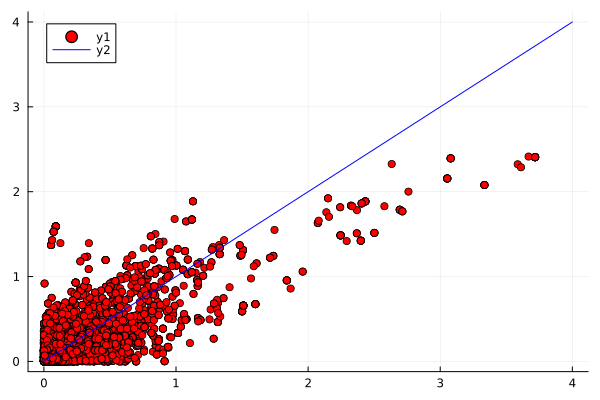

In [91]:
scatter(lp1_scan_strains.lod, lp1_scan_ind.lod, color = "red")# , label = "individuals");
plot!(x -> x, 0, 4, color = "blue")
# scatter!(lp1_scan_strains.lod, color = "green", label = "strains");

In [92]:
scatter(lp1_scan_ind.lod, color = "red", label = "individuals");
scatter!(lp1_scan_strains.lod, color = "green", label = "strains");
hline!(thrs_strains, label = "", color = "blue")

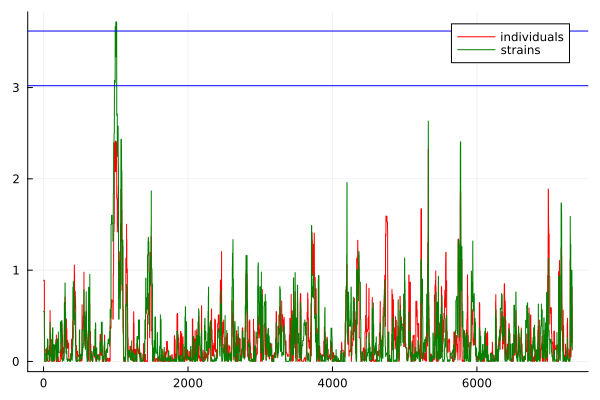

In [93]:
plot(lp1_scan_ind.lod, color = "red", label = "individuals");
plot!(lp1_scan_strains.lod, color = "green", label = "strains");
hline!(thrs_ind, label = "", color = "blue")

In [94]:
lp1_scan_ind.h2_null # individuals

0.10886902467764013

In [95]:
lp1_scan_strains.h2_null # strain means

3.324562949461316e-16

In [96]:
counting_dict

Dict{Int64, Int64} with 50 entries:
  56 => 1
  55 => 1
  60 => 3
  32 => 8
  67 => 2
  45 => 5
  73 => 7
  64 => 3
  90 => 6
  13 => 1
  63 => 12
  86 => 4
  91 => 2
  62 => 5
  75 => 2
  43 => 4
  69 => 5
  68 => 2
  98 => 5
  39 => 5
  84 => 2
  77 => 6
  95 => 5
  66 => 5
  34 => 13
  ⋮  => ⋮

In [97]:
reps_each_strain = map(x -> counting_dict[x], unique(BXD_summary_df.Strain_num));
geno_strains

50×7321 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [98]:
kinship_strains[1, 1]

1.0

In [99]:
BXD_summary_df[1:10, 1:10]

10×10 DataFrame
 Row │ Sample  Proteomic  Strain  Strain_num  rs31443144  rs6269442  rs3228518 ⋯
     │ Any     Any        Any     Int64       Any         Any        Any       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ H1009   11.349     BXD9             9  0.0         0.0        0.0       ⋯
   2 │ H0370   11.249     BXD9             9  0.0         0.0        0.0
   3 │ H2577   12.415     BXD9             9  0.0         0.0        0.0
   4 │ H0365   11.374     BXD9             9  0.0         0.0        0.0
   5 │ H1333   11.687     BXD13           13  0.0         0.0        0.0       ⋯
   6 │ H2259   11.837     BXD24           24  0.0         0.0        0.0
   7 │ H1792   11.563     BXD24           24  0.0         0.0        0.0
   8 │ H1791   12.5       BXD24           24  0.0         0.0        0.0
   9 │ H1541   11.815     BXD24           24  0.0         0.0        0.0       ⋯
  10 │ H1277   12.674     BXD24           24  0.0         0.0        0.0
                                                               4 columns omitted

In [100]:
@btime combine(groupby(BXD_summary_df[:, [:Sample, :Strain]], :Strain), nrow => :count);

  66.970 μs (498 allocations: 33.58 KiB)


In [101]:
@btime calcRepeats(BXD_summary_df.Strain_num);

  4.479 μs (10 allocations: 6.36 KiB)


In [102]:
BXD_summary_df.Strain_num

248-element Vector{Int64}:
   9
   9
   9
   9
  13
  24
  24
  24
  24
  24
  27
  27
  27
   ⋮
 102
 102
 102
 102
 102
 102
 102
 102
 102
 102
 102
 102

In [103]:
function calcIndKinship_from_StrainKinship(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = Matrix{Float64}(undef, sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] = k_11 * block_11

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] = k_1j * block_1j;

        # process the off-diagonal block conveniently...
        block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] = k_1j * block_j1;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] = k_ii * block_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            block_ij = ones(reps_strain_i, reps_strain_j);

            kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] = k_ij * block_ij;

            # process the off-diagonal block conveniently...
            block_ji = ones(reps_strain_j, reps_strain_i);
            kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] = k_ij * block_ji;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship (generic function with 1 method)

In [104]:
function calcIndKinship_from_StrainKinship_c(kinship_strains::Array{Float64, 2}, 
                                           strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second BXD strain and all after...
    # for i in 2:length(reps_each_strain)
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;

        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            @views kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            @views kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship_c (generic function with 1 method)

In [105]:
function calcIndKinship_from_StrainKinship_c2(kinship_strains::Array{Float64, 2}, 
                                              strain_info_about_samples::Array{Int64, 1})
    
    counting_dict = calcRepeats(strain_info_about_samples);
    reps_each_strain = map(x -> counting_dict[x], unique(strain_info_about_samples));
    
    # Initialize the placeholder:
    kinship_ind_from_strains = ones(sum(reps_each_strain), sum(reps_each_strain));

    # process the first BXD strain...
    reps_strain_1 = reps_each_strain[1];
    k_11 = kinship_strains[1, 1];
    # block_11 = ones(reps_strain_1, reps_strain_1);

    row_id = 0;
    col_id = 0;

    kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                             (row_id+1):(row_id+reps_strain_1)] .*= k_11;

    # for the first strain, fill in the block_1j for j = 2, ..., num_of_strains
    for j in 2:length(reps_each_strain)
        reps_strain_j = reps_each_strain[j];
        k_1j = kinship_strains[1, j];
        # block_1j = ones(reps_strain_1, reps_strain_j);

        col_id += reps_each_strain[j-1];
        kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_1), 
                                 (col_id+1):(col_id+reps_strain_j)] .*= k_1j;

        # process the off-diagonal block conveniently...
        # block_j1 = ones(reps_strain_j, reps_strain_1);
        kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                 (row_id+1):(row_id+reps_strain_1)] .*= k_1j;

    end

    # process for the second strain and all after...
    for i in 2:length(reps_each_strain)

        reps_strain_i = reps_each_strain[i];
        k_ii = kinship_strains[i, i];
        # block_ii = ones(reps_strain_i, reps_strain_i);

        row_id += reps_each_strain[i-1];
        kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                 (row_id+1):(row_id+reps_strain_i)] .*= k_ii;

        col_id = row_id+reps_strain_i;
        
        # for strain i, fill in the block_ij for all j = i+1, ..., num_of_strains
        for j in (i+1):length(reps_each_strain)

            reps_strain_j = reps_each_strain[j];
            k_ij = kinship_strains[i, j];
            # block_ij = ones(reps_strain_i, reps_strain_j);

            kinship_ind_from_strains[(row_id+1):(row_id+reps_strain_i), 
                                     (col_id+1):(col_id+reps_strain_j)] .*= k_ij;

            # process the off-diagonal block conveniently...
            # block_ji = ones(reps_strain_j, reps_strain_i);
            kinship_ind_from_strains[(col_id+1):(col_id+reps_strain_j),
                                     (row_id+1):(row_id+reps_strain_i)] .*= k_ij;

            col_id += reps_each_strain[j];
        end
    
    end
    
    return kinship_ind_from_strains
end

calcIndKinship_from_StrainKinship_c2 (generic function with 1 method)

In [106]:
@time kinship_ind_from_strains = calcIndKinship_from_StrainKinship(kinship_strains, BXD_summary_df.Strain_num);

  0.001163 seconds (5.03 k allocations: 1.727 MiB)


In [107]:
@time kinship_ind_from_strains_c = calcIndKinship_from_StrainKinship_c(kinship_strains, BXD_summary_df.Strain_num);

  0.000318 seconds (76 allocations: 503.766 KiB)


In [108]:
@time kinship_ind_from_strains_c2 = calcIndKinship_from_StrainKinship_c2(kinship_strains, BXD_summary_df.Strain_num);

  0.000514 seconds (2.53 k allocations: 1.104 MiB)


In [109]:
# for comparison...
@time kinship_ind_from_ind = calcKinship(geno_ind);

  8.672137 seconds (306.28 k allocations: 8.368 GiB, 14.72% gc time)


In [110]:
kinship_ind_from_ind

248×248 Matrix{Float64}:
 1.0       0.998702  0.998702  0.998702  …  0.549925  0.549925  0.549925
 0.998702  1.0       0.998702  0.998702     0.549925  0.549925  0.549925
 0.998702  0.998702  1.0       0.998702     0.549925  0.549925  0.549925
 0.998702  0.998702  0.998702  1.0          0.549925  0.549925  0.549925
 0.554842  0.554842  0.554842  0.554842     0.531895  0.531895  0.531895
 0.583732  0.583732  0.583732  0.583732  …  0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.583732  0.583732  0.583732  0.583732     0.540227  0.540227  0.540227
 0.529504  0.529504  0.529504  0.529504  …  0.557984  0.557984  0.557984
 0.529504  0.529504  0.529504  0.529504     0.557984  0.557984  0.557984
 0.529504  0.529504  0.529504  0.529504     0.557984  0.557984  0.557984
 ⋮                        

In [111]:
maximum(abs.(kinship_ind_from_strains .- kinship_ind_from_ind))

0.04186586531894554

In [112]:
maximum(abs.(kinship_ind_from_strains .- kinship_ind_from_strains_c))

0.0

In [113]:
size(kinship_ind_from_strains)

(248, 248)

In [114]:
size(kinship_ind_from_ind)

(248, 248)

### Multiple traits scans:

In [151]:
geno_ind

248×7321 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [150]:
BXD_lp_ind_all

248×32445 Matrix{Float64}:
 11.349  11.534  17.587  17.517  17.309  …  15.825   8.429  14.276  13.392
 11.249  12.735  17.427  17.325  17.252     15.136   8.425  14.603  13.094
 12.415  10.487  17.89   17.488  17.594     13.997   5.682  13.909  13.551
 11.374  10.674  17.714  17.401  17.381     17.173   7.018  14.22   13.308
 11.687  11.524  17.362  17.367  17.071     14.731   8.956  14.501  13.073
 11.837  11.715  17.57   17.792  17.505  …  16.548   8.57   14.62   12.916
 11.563  11.434  17.789  17.847  17.416     15.987   7.601  14.351  13.246
 12.5    12.273  17.944  17.833  17.63      16.067   8.966  14.631  13.535
 11.815  11.564  17.794  17.759  17.456     14.59    8.149  14.55   12.945
 12.674  11.743  17.866  17.845  17.577     16.173   7.778  13.82   12.682
 11.494  11.184  17.437  17.346  17.261  …  15.744   7.231  14.603  13.064
 12.449  10.938  16.995  17.161  16.911     15.202   5.656  14.712  13.396
 11.208  11.325  17.576  17.436  17.323     14.496   6.537  14.636  13.33

In [152]:
size(BXD_lp_ind_all)

(248, 32445)

In [156]:
BLAS.get_num_threads()

4

In [159]:
@time lp_all_ind_grid = bulkscan_null_grid(BXD_lp_ind_all[1:50, :], geno_ind[1:50, :], kinship_ind_from_strains[1:50, 1:50], collect(0.0:0.05:0.95))

LoadError: Dividing by zeros: the input vector can not contain any zeros!

In [160]:
hcat(lp_all_ind_grid[:, 1], lp1_scan_ind.lod)

7321×2 Matrix{Float64}:
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.903884  0.888944
 0.382075  0.378313
 ⋮         
 0.291699  0.287684
 0.291699  0.287684
 0.291699  0.287684
 0.705392  0.699309
 0.81752   0.809842
 0.81752   0.809842
 0.604744  0.596119
 0.456187  0.449392
 0.604744  0.596119
 0.456187  0.449392
 0.211429  0.205709
 0.211429  0.205709

## Next:

- gemma one trait, ind and strains

- scan_alt one trait, ind and strains

- scan_null one trait, ind and strains

- bulkscan_grid (null), all traits, ...

- data structure for all traits results...

- Heatmap grids_taken, compare on strain means and individuals

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

- Loglikelihood by h2_grid plot, strain means v.s. individuals

- Report fixed effects:

- Adjusting difference in the number of samples across strains

- Histogram of heritabilities (null) for all traits (both strain means and individual level data)

In [115]:
pheno_covar = readdlm(joinpath(datafolder_path, "GN886_liver_proteome_data_individuals_annot_rev020823.txt"), '\t')

32446×2575 Matrix{Any}:
 "ProbeSet"                                       …  "L3159"  "L3160"  "L2997"  ""
 "P42209_DESGLNRK_2"                                 "x"      "x"      "x"      ""
 "P42209_GLRPLDVAFLR_3"                              "x"      "x"      "x"      ""
 "Q99M02_VGDPVYR_2"                                  "x"      "x"      "x"      ""
 "Q99M02_VWIYPIK_2"                                  "x"      "x"      "x"      ""
 "Q99M02_LCDPSVK_2"                               …  "x"      "x"      "x"      ""
 "Q99M02_CVLTTVDPDTGIIDR_2"                          "x"      "x"      "x"      ""
 "Q99M02_LVQFDTSMK_2"                                "x"      "x"      "x"      ""
 "Q99M02_QLQQVGTVSK_2"                               "x"      "x"      "x"      ""
 "Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4"     "x"      "x"      "x"      ""
 "Q99M02_GRDCGDEVAQWFTNYLK_3"                     …  "x"      "x"      "x"      ""
 "Q99M02_SIYQSSPLFGMYFSVEK_2"                        "x"      "

In [116]:
size(pheno_covar)

(32446, 2575)

In [117]:
pheno_covar[1:10, 1:5]

10×5 Matrix{Any}:
 "ProbeSet"                                       …    "Chr"     "Mb"         "Gene Id"
 "P42209_DESGLNRK_2"                                  7       127.214    54204
 "P42209_GLRPLDVAFLR_3"                               7       127.214    54204
 "Q99M02_VGDPVYR_2"                                  17        33.6857  224703
 "Q99M02_VWIYPIK_2"                                  17        33.6857  224703
 "Q99M02_LCDPSVK_2"                               …  17        33.6857  224703
 "Q99M02_CVLTTVDPDTGIIDR_2"                          17        33.6857  224703
 "Q99M02_LVQFDTSMK_2"                                17        33.6857  224703
 "Q99M02_QLQQVGTVSK_2"                               17        33.6857  224703
 "Q99M02_KLYPSESYLQNYEVAYPDCSPVHLISEASLVDLNTR_4"     17        33.6857  224703

In [118]:
# column names of pheno_covar:
colNames_pheno_covar = pheno_covar[1, :]

2575-element Vector{Any}:
 "ProbeSet"
 "Gene Symbol"
 "Chr"
 "Mb"
 "Gene Id"
 "Strand Gene"
 "Blat Mb Start"
 "Blat Mb End"
 "Description"
 "Aliases"
 "Blat Sequence"
 "UniGeneId"
 "OMIM"
 ⋮
 "L2778"
 "L2779"
 "L2808"
 "L2809"
 "L3059"
 "L3157"
 "L2780"
 "L3158"
 "L3159"
 "L3160"
 "L2997"
 ""

In [119]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM_Analyses/BXDLongevity"